## Session 2: Baseline Forecasting Models & Validation Strategy

### Objective
Establish strong, time-aware baseline models that define the minimum
acceptable performance for multi-horizon forecasting.

### Why This Matters
Baseline models serve as:
- Performance floors
- Production fallbacks
- Drift detection references

### Key Outcomes
- Time-aware evaluation strategy
- Horizon-specific performance baselines
- Error behavior understanding for future drift detection

## Importing daily_sales parquet exported from: 01_data_exploration.ipynb in: data\processed

In [1]:
import pandas as pd


from pathlib import Path
import sys

# Dynamically locate project root
PROJECT_ROOT = Path.cwd()
while not (PROJECT_ROOT / "config").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent

sys.path.append(str(PROJECT_ROOT))


from config.paths import DATA_DIR

daily_sales = pd.read_parquet(
    DATA_DIR / "daily_sales.parquet"
)

In [2]:
daily_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1913 entries, 0 to 1912
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1913 non-null   datetime64[ns]
 1   sales   1913 non-null   int64         
 2   dow     1913 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 45.0+ KB


## Forecasting Setup

- Time granularity: Daily
- Target variable: Total units sold per day
- Known information at prediction time:
  - Past sales
  - Calendar features (day of week)
- Forecast horizons:
  - Short: 1 day
  - Medium: 7, 14 days
  - Long: 28 days

## Sort & Index

In [3]:
daily_sales = daily_sales.sort_values("date")
daily_sales = daily_sales.reset_index(drop=True)

## Train–Validation Split (Reality Simulation)

In [4]:
split_date = "2015-12-31"

train = daily_sales[daily_sales["date"] <= split_date]
test  = daily_sales[daily_sales["date"] > split_date]

#### Validation Strategy
We mimic real deployment by ensuring all forecasts are generated
using strictly historical information.

## Metric Choice : Why RMSE (for now)?
### Evaluation Metric
RMSE is used because:
- Penalizes large errors
- Stable under aggregation
- Suitable for baseline comparison

MAPE is avoided due to zero-heavy demand.

Later we’ll add:

- sMAPE

- weighted RMSE

## Baseline Model 1 — Naive Forecast

In [5]:
import numpy as np

def naive_forecast(train_series, horizon):
    last_value = train_series.iloc[-1]
    return np.repeat(last_value, horizon)

In [6]:
horizon = 1

y_true = test["sales"].values[:horizon]
y_pred = naive_forecast(train["sales"], horizon)

rmse_naive = np.sqrt(
    np.mean((y_true - y_pred) ** 2)
)

print("RMSE:", rmse_naive)

RMSE: 10408.0


#### Interpretation:

- This is our absolute floor

- Any ML model failing this is discarded

- "For a single-step forecast, RMSE collapses to absolute error, but for multi-horizon forecasting we must average squared errors across time."

## Baseline Model 2 — Moving-Average

In [7]:
def moving_average_forecast(train_series, window, horizon):
    avg = train_series.iloc[-window:].mean()
    return np.repeat(avg, horizon)

In [8]:
horizon = 7
windows = [7, 14, 28]

for w in windows:
    y_pred = moving_average_forecast(train["sales"], w, horizon)
    rmse = np.sqrt(
        np.mean((y_true - y_pred) ** 2)
    )
    print(f"Window={w:>2} → RMSE={rmse:.2f}")

Window= 7 → RMSE=2249.29
Window=14 → RMSE=1719.00
Window=28 → RMSE=3765.32


#### Interpretation 

- Smaller window → reacts faster, noisier

- Larger window → smoother, slower to adapt

- There is no universal best window

## Rolling-Origin Evaluation (Production Simulation)

In [9]:
def rolling_origin_rmse(series, window, horizon, model="naive"):
    errors = []

    values = series.values

    for i in range(len(values) - window - horizon):
        train_slice = values[: window + i]
        test_slice  = values[window + i : window + i + horizon]

        if model == "naive":
            preds = np.repeat(train_slice[-1], horizon)
        elif model == "moving_average":
            preds = np.repeat(train_slice[-window:].mean(), horizon)
        else:
            raise ValueError("Unknown model type")

        rmse = np.sqrt(
            np.mean((test_slice - preds) ** 2)
        )
        errors.append(rmse)

    return np.mean(errors)

## Horizon-Wise Baseline Performance

In [10]:
horizons = [1, 7, 14, 28]

baseline_results = []

for h in horizons:
    rmse = rolling_origin_rmse(
        daily_sales["sales"],
        window=28,
        horizon=h,
        model="moving_average"
    )
    baseline_results.append((h, rmse))

baseline_df = pd.DataFrame(
    baseline_results,
    columns=["Horizon", "RMSE"]
)

baseline_df

,Horizon,RMSE
0,1,4669.033894
1,7,5671.193037
2,14,5743.932217
3,28,5825.547744


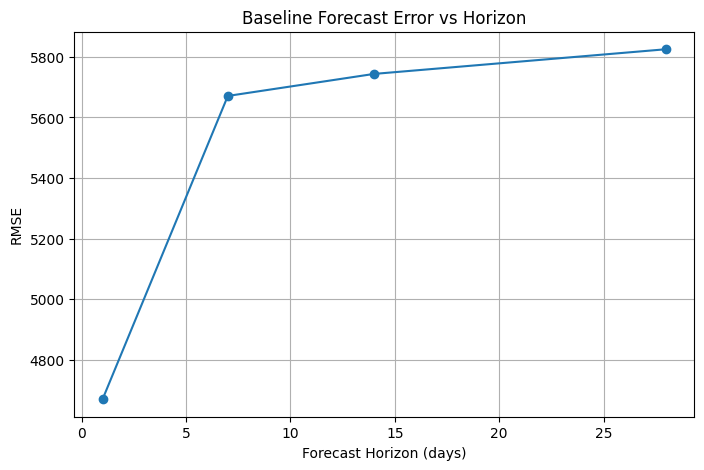

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(
    baseline_df["Horizon"],
    baseline_df["RMSE"],
    marker="o"
)
plt.xlabel("Forecast Horizon (days)")
plt.ylabel("RMSE")
plt.title("Baseline Forecast Error vs Horizon")
plt.grid(True)
plt.show()

#### Interpretation
- Error increases non-linearly
- Long horizons are inherently uncertain
- Any ML model must beat these per horizon

## Session 2 – Final Insights

1. Naïve and moving-average baselines capture strong short-term structure.
2. Proper RMSE requires aggregation across forecast horizons.
3. Rolling-origin evaluation reveals realistic performance degradation.
4. Baseline errors form the reference distribution for drift detection.

## Common Pitfalls Avoided

-  Treating absolute error as RMSE (i did rmse = np.sqrt((y_true-y_pred)**2)  earlier which is error free and fine for just 1 metric but when we do this for different windows, this breaks, and its not actual rmse, it is absolute error: My earlier one-liner is only accidentally correct for horizon = 1 & number of errors n=1, But only under this very specific condition): so we fixed it later as in cell:20
  
    - y_true = test.iloc[0]["sales"]
   
      y_pred = naive_forecast(train["sales"], horizon=1)[0]

      rmse_naive = np.sqrt((y_true - y_pred) ** 2)

      rmse_naive

   
    - Why it “worked” anyway?

    - Because we implicitly had:
      horizon = 1
      n=1

    - And RMSE is defined as:
        - RMSE = √1/n summation(y-y_pred)**2
        - When n=1:
          RMSE = √(y-y_pred)**2
          - ✅ Same numeric value
          - ❌ But only under this very specific condition
    - so this got accidentally correct

-  Evaluating only single-step forecasts
-  Using random cross-validation
-  Ignoring horizon-specific difficulty